# RNA-seq comparison vs H3K4me3 and H3K36me3

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import pyranges as pr
from pyranges import PyRanges
import tempfile

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n > {ts}
    # Fixes of problems with peakseq output
    ! sed -E -i 's/[[:space:]]+/\t/g' {ts}
    ! sed -E -i 's/\t$//g' {ts}
    return ts

# Load hg38 peaks


In [3]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [4]:
TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'Peakseq', 'LanceOtron', 'Omnipeak']
palette = plt.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [5]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [6]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_omnipeak = load_peaks(os.path.join(path, 'omnipeak'), '.peak', modifications, cells, replicates)
    # df_omnipeak = df_omnipeak[['_200_' in f for f in df_omnipeak['file']]]
    df_omnipeak['tool'] = 'Omnipeak'
    print('Omnipeak', len(df_omnipeak))

    df_homer = load_peaks(os.path.join(path, 'homer'), '.peaks', modifications, cells, replicates)
    df_homer['tool'] = 'HOMER'
    print('HOMER', len(df_homer))

    df_hotspot = load_peaks(os.path.join(path, 'hotspot'), '.peak', modifications, cells, replicates)
    df_hotspot['tool'] = 'Hotspot'
    print('Hotspot', len(df_hotspot))

    df_peakseq = load_peaks(os.path.join(path, 'peakseq'), '.narrowPeak', modifications, cells, replicates)
    df_peakseq['tool'] = 'Peakseq'
    print('Peakseq', len(df_peakseq))

    df_lanceotron = load_peaks(os.path.join(path, 'lanceotron'), '.bed', modifications, cells, replicates)
    df_lanceotron['tool'] = 'LanceOtron'
    print('LanceOtron', len(df_lanceotron))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_omnipeak, df_homer, df_hotspot, df_peakseq, df_lanceotron]).reset_index(drop=True)

In [7]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 33


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 33


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 33


  0%|          | 0/358 [00:00<?, ?it/s]

Omnipeak 33


  0%|          | 0/85 [00:00<?, ?it/s]

HOMER 33


  0%|          | 0/85 [00:00<?, ?it/s]

Hotspot 33


  0%|          | 0/171 [00:00<?, ?it/s]

Peakseq 33


  0%|          | 0/170 [00:00<?, ?it/s]

LanceOtron 33


,file,modification,cell,replicate,peaks,tool,dataset
19,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K36me3,HepG2,rep2,3561,MACS2,ENCODE
234,/home/jetbrains/data/2023_GSE26320/lanceotron/...,H3K36me3,GM12878,rep1,303364,LanceOtron,ENCODE
175,/home/jetbrains/data/2023_GSE26320/hotspot/GSM...,H3K4me3,NHEK,rep1,153305,Hotspot,ENCODE
62,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K4me3,HepG2,rep2,24303,MACS2 broad,ENCODE
236,/home/jetbrains/data/2023_GSE26320/lanceotron/...,H3K4me3,HSMM,rep2,83256,LanceOtron,ENCODE


In [8]:
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks.sample(5)

  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 20


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 20


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 20


  0%|          | 0/194 [00:00<?, ?it/s]

Omnipeak 20


  0%|          | 0/46 [00:00<?, ?it/s]

HOMER 20


  0%|          | 0/46 [00:00<?, ?it/s]

Hotspot 20


  0%|          | 0/94 [00:00<?, ?it/s]

Peakseq 20


  0%|          | 0/92 [00:00<?, ?it/s]

LanceOtron 20


,file,modification,cell,replicate,peaks,tool,dataset
158,/home/jetbrains/data/2023_Immune/lanceotron/TC...,H3K4me3,TCell,,44771,LanceOtron,Roadmap
90,/home/jetbrains/data/2023_Immune/homer/TCell_H...,H3K4me3,TCell,,22431,HOMER,Roadmap
20,/home/jetbrains/data/2023_Immune/macs2/TCellBB...,H3K4me3,TCellBB,rep2,36439,MACS2 broad,Roadmap
152,/home/jetbrains/data/2023_Immune/lanceotron/PB...,H3K36me3,PBMC,,140893,LanceOtron,Roadmap
110,/home/jetbrains/data/2023_Immune/hotspot/CD4_H...,H3K36me3,CD4,,292716,Hotspot,Roadmap


In [9]:
df_peaks_full = pd.concat([df_encode_peaks, df_immune_peaks]).reset_index(drop=True)

In [10]:
# Remove outliers, see figures.ipynb
OUTLIERS = [
    ('H3K4me3', 'NK', ''),
    ('H3K27ac', 'CD34', 'rep2'),
    ('H3K4me1', 'NK', ''),
    ('H3K27me3', 'BCell', ''),
    ('H3K27me3', 'TCell', ''),
    ('H3K27me3', 'NK', ''),
]
df_peaks = df_peaks_full.loc[[(m, c, r) not in OUTLIERS
                              for _, (m, c, r) in df_peaks_full[['modification', 'cell', 'replicate']].iterrows()]].copy()

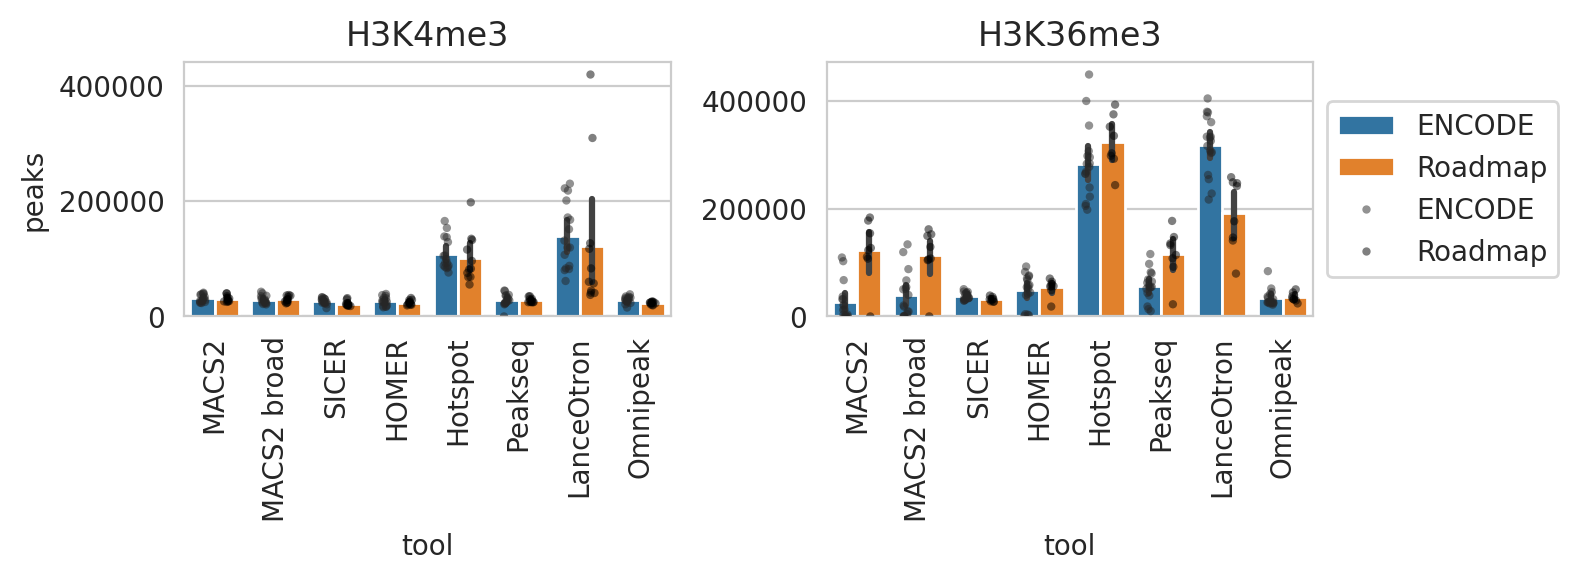

In [11]:
plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
                # capsize=.2, err_kws={'linewidth': 2}, edgecolor="black",
                # palette=TOOLS_PALETTE,
                order=TOOLS,
                ax=ax)
    sns.stripplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks',  hue='dataset',
                  dodge=True, size=3, palette="dark:black", alpha=0.5,
                  order=TOOLS,
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# RNA-seq vs

Benchmark according to the paper https://doi.org/10.1093/bib/bbw035
Features that define the best ChIP-seq peak calling algorithms

We considered a peak as positive if it overlaps the promoter of an expressed gene (RPKM > 0.5).
The top 15 000 peak calls from the different methods are ranked by their significance or by their fold enrichment for the thresholding method. We plotted the correct peak fraction (fraction of the top 1000xn peaks that overlap with active promoters) detected as a function of the correct promoter fraction (fraction of the active promoters that overlap with the top 1000xn peaks).

In [12]:
# V29 was used with RSEM for genes quantification in ENCODE pipeline

print('Parse GTF data')
gtf_df = pd.read_csv(os.path.expanduser('~/data/gencode.v29.annotation.gtf'),
    sep='\t', comment='#',
    names=['chromosome', 'db', 'type', 'start', 'end', 'point1', 'strand', 'point2', 'aux'])
print(len(gtf_df))
gtf_df.head(5)

Parse GTF data
2742017


,chromosome,db,type,start,end,point1,strand,point2,aux
0,chr1,HAVANA,gene,11869,14409,.,+,.,"gene_id ""ENSG00000223972.5""; gene_type ""transc..."
1,chr1,HAVANA,transcript,11869,14409,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN..."
2,chr1,HAVANA,exon,11869,12227,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN..."
3,chr1,HAVANA,exon,12613,12721,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN..."
4,chr1,HAVANA,exon,13221,14409,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN..."


In [13]:
import re
print('Parse GTF aux data')
auxes = {}
for i, aux in enumerate(tqdm(gtf_df['aux'])):
    for pair in aux.split(';'):
        kv = pair.strip().split(' ')
        if len(kv) != 2:
            continue
        k, v = kv
        if k not in auxes:
            auxes[k] = vs = []
        else:
            vs = auxes[k]
        vs.append(v.strip('"'))

for k, vs in auxes.items():
    if len(vs) == len(gtf_df):
        gtf_df[k] = vs
    else:
        print(f'Ignoring {k}')
del auxes
gtf_df.drop('aux', axis=1, inplace=True)

print(len(gtf_df))
# Fix . suffix in gene_id
gtf_df['gene_id'] = [re.sub('\\..*', '', gid) for gid in gtf_df['gene_id']]

gtf_df.head(5)

Parse GTF aux data


  0%|          | 0/2742017 [00:00<?, ?it/s]

Ignoring havana_gene
Ignoring transcript_id
Ignoring transcript_type
Ignoring transcript_name
Ignoring transcript_support_level
Ignoring tag
Ignoring havana_transcript
Ignoring exon_number
Ignoring exon_id
Ignoring ont
Ignoring protein_id
Ignoring ccdsid
2742017


,chromosome,db,type,start,end,point1,strand,point2,gene_id,gene_type,gene_name,level
0,chr1,HAVANA,gene,11869,14409,.,+,.,ENSG00000223972,transcribed_unprocessed_pseudogene,DDX11L1,2
1,chr1,HAVANA,transcript,11869,14409,.,+,.,ENSG00000223972,transcribed_unprocessed_pseudogene,DDX11L1,2
2,chr1,HAVANA,exon,11869,12227,.,+,.,ENSG00000223972,transcribed_unprocessed_pseudogene,DDX11L1,2
3,chr1,HAVANA,exon,12613,12721,.,+,.,ENSG00000223972,transcribed_unprocessed_pseudogene,DDX11L1,2
4,chr1,HAVANA,exon,13221,14409,.,+,.,ENSG00000223972,transcribed_unprocessed_pseudogene,DDX11L1,2


In [14]:
print(f'Total hg38 records {len(gtf_df)}')
print(f'Total hg38 transcript {sum((gtf_df["type"] == "transcript"))}')
print(f'Total hg38 genes {sum((gtf_df["type"] == "gene"))}')
print(f'Total hg38 protein coding transcripts {sum((gtf_df["type"] == "gene") & (gtf_df["gene_type"] == "protein_coding"))}')
gtf_genes_df = gtf_df[(gtf_df["type"] == "gene")]
print(len(gtf_genes_df))
gtf_genes_df.head(5)

Total hg38 records 2742017
Total hg38 transcript 206694
Total hg38 genes 58721
Total hg38 protein coding transcripts 19940
58721


,chromosome,db,type,start,end,point1,strand,point2,gene_id,gene_type,gene_name,level
0,chr1,HAVANA,gene,11869,14409,.,+,.,ENSG00000223972,transcribed_unprocessed_pseudogene,DDX11L1,2
12,chr1,HAVANA,gene,14404,29570,.,-,.,ENSG00000227232,unprocessed_pseudogene,WASH7P,2
25,chr1,ENSEMBL,gene,17369,17436,.,-,.,ENSG00000278267,miRNA,MIR6859-1,3
28,chr1,HAVANA,gene,29554,31109,.,+,.,ENSG00000243485,lincRNA,MIR1302-2HG,2
36,chr1,ENSEMBL,gene,30366,30503,.,+,.,ENSG00000284332,miRNA,MIR1302-2,3


## Annotate quanitified RNA-seq with positions

In [15]:
import re

GSE26320_RNASEQ_PATH = os.path.expanduser('~/data/2023_GSE26320_rnaseq')

GSE26320_EXPRESSION_TSV = {
    ('GM12878', 'rep1') : GSE26320_RNASEQ_PATH + '/GM12878_rep1_RNAseq_hg38_ENCFF723ICA.tsv',
    ('GM12878', 'rep2'): GSE26320_RNASEQ_PATH + '/GM12878_rep2_RNAseq_hg38_ENCFF418FIT.tsv',
    ('H1', 'rep1') : GSE26320_RNASEQ_PATH + '/H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv',
    ('H1', 'rep2') : GSE26320_RNASEQ_PATH + '/H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv',
    ('HMEC', 'rep1') : GSE26320_RNASEQ_PATH + '/HMEC_rep1_RNAseq_hg38_ENCFF292FVY.tsv',
    ('HMEC', 'rep2') : GSE26320_RNASEQ_PATH + '/HMEC_rep2_RNAseq_hg38_ENCFF219EZH.tsv',
    ('HSMM', 'rep1') : GSE26320_RNASEQ_PATH + '/HSMM_rep1_RNAseq_hg38_ENCFF551YKI.tsv',
    ('HSMM', 'rep2') : GSE26320_RNASEQ_PATH + '/HSMM_rep2_RNAseq_hg38_ENCFF497BUG.tsv',
    ('HepG2', 'rep1') : GSE26320_RNASEQ_PATH + '/HepG2_rep1_RNAseq_hg38_ENCFF773JNC.tsv',
    ('HepG2', 'rep2') : GSE26320_RNASEQ_PATH + '/HepG2_rep2_RNAseq_hg38_ENCFF570ZOT.tsv',
    ('Huvec', 'rep1') : GSE26320_RNASEQ_PATH + '/Huvec_rep1_RNAseq_hg38_ENCFF454MTF.tsv',
    ('Huvec', 'rep2') : GSE26320_RNASEQ_PATH + '/Huvec_rep2_RNAseq_hg38_ENCFF134FYP.tsv',
    ('K562', 'rep1') : GSE26320_RNASEQ_PATH + '/K562_rep1_RNAseq_hg38_ENCFF139IXQ.tsv',
    ('K562', 'rep2') : GSE26320_RNASEQ_PATH + '/K562_rep2_RNAseq_hg38_ENCFF088RDE.tsv',
    ('NHEK', 'rep1') : GSE26320_RNASEQ_PATH + '/NHEK_rep1_RNAseq_hg38_ENCFF004JWA.tsv',
    ('NHEK', 'rep2') : GSE26320_RNASEQ_PATH + '/NHEK_rep1_RNAseq_hg38_ENCFF004JWA.tsv',
    ('NHLF', 'rep1') : GSE26320_RNASEQ_PATH + '/NHLF_rep1_RNAseq_hg38_ENCFF577DEC.tsv',
    ('NHLF', 'rep2') : GSE26320_RNASEQ_PATH + '/NHLF_rep2_RNAseq_hg38_ENCFF412KNK.tsv'
}

In [16]:
IMMUNE_EXPRESSION_TSV = {
    ('BCell', ''): IMMUNE_PATH + '/expression/BCell_RNAseq_hg38_ENCFF947SKG.tsv',
    ('TCell', ''): IMMUNE_PATH + '/expression/TCell_RNAseq_hg38_ENCFF502AZI.tsv',
    ('Monocyte', ''): IMMUNE_PATH + '/expression/Monocyte_RNAseq_hg38_ENCFF408GAO.tsv',
}

## Prepare track with TSS / Bodies of expressed genes

In [17]:
def merge_genes(full_df):
    print('Merging overlapping regions', len(full_df))
    ts = []
    for chr in full_df['chromosome'].unique():
        t = full_df[full_df['chromosome'] == chr].sort_values(by=['start', 'end']).copy()
        cols = t.columns.difference(['start', 'end', 'chromosome', 'gene_id', 'strand'])
        grps = t['start'].sub(t['end'].shift()).gt(1).cumsum()
        gpby = t.groupby(grps)
        t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
        t['chromosome'] = chr
        t['gene_id'] = 'merged'
        t['strand'] = '.'
        t = t[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM']]
        ts.append(t)
    ts = pd.concat(ts).reset_index(drop=True)
    print('Reduced to', len(ts))
    return ts

In [18]:
TSS = 500  # TSS width
EXPRESSED = 15_000  # Top expressed protein coding genes

def prepare_expressed(expression_tsv):
    result_tss = {}
    result_gene = {}
    for (cell, rep), path in tqdm(expression_tsv.items()):
        t = pd.read_csv(path, sep='\t')
        # Fix . suffix in gene_id
        t['gene_id'] = [re.sub('\\..*', '', gid) for gid in t['gene_id']]
        t['name'] = f'{cell} {rep}'
        print(cell, rep, path, len(t))

        full_df = pd.merge(left=t, right=gtf_genes_df, left_on='gene_id', right_on='gene_id')
        print(f'Total genes with positions {len(full_df)}')

        # Compute expression threshold
        tpms = list(full_df['TPM'])
        if len(tpms) <= EXPRESSED:
            print('Not enough genes with locations to proceed')
        tpms.sort(reverse=True)
        threshold = tpms[min(EXPRESSED, len(tpms) - 1)]
        print(f'TOP {EXPRESSED} threshold {threshold}')

        # Save expressed genes
        full_df = full_df[full_df['TPM'] > threshold].copy()
        full_df.sort_values(by=['chromosome', 'start'], inplace=True)

        gene_path = path.replace('.tsv', f'_expr_bodies.bed')
        full_df[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM']].to_csv(
            gene_path, sep='\t', index=False, header=None)
        print(f'Saved body expressed genes fom {cell} to {gene_path}')
        result_gene[(cell, rep)] = gene_path

        starts = [
            max(1, start - TSS if strand == '+' else end - TSS)
            for start, end, strand in zip(full_df['start'], full_df['end'], full_df['strand'])
        ]
        ends = [
            start + TSS if strand == '+' else end + TSS
            for start, end, strand in zip(full_df['start'], full_df['end'], full_df['strand'])
        ]
        full_df['start'] = starts
        full_df['end'] = ends
        full_df = full_df[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM']]
        full_df.sort_values(by=['chromosome', 'start', 'end'], inplace=True)
        full_df = merge_genes(full_df)

        tss_path = path.replace('.tsv', f'_expr_tss{TSS}.bed')
        full_df.to_csv(tss_path, sep='\t', index=False, header=None)
        print(f'Saved TSS expressed genes fom {cell} to {tss_path}')
        result_tss[(cell, rep)] = tss_path

        # print('Plot expression')
        # plt.figure(figsize=(7, 2))
        # ax = plt.axes()
        # sns.histplot(data=pd.concat(ts).reset_index(drop=True),
        #              x='TPM', stat='density', bins=500, kde=True, alpha=0.4,
        #              ax=ax)
        # ax.axvline(x=threshold, color='green')
        # ax.title.set_text('Expression')
        # ax.set_xlim(0, 3)
        # ax.set(xscale='log')
        # plt.tight_layout()
        # plt.show()
    return result_gene, result_tss

In [19]:
encode_expression, encode_tss_expression = prepare_expressed(GSE26320_EXPRESSION_TSV)

  0%|          | 0/18 [00:00<?, ?it/s]

GM12878 rep1 /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep1_RNAseq_hg38_ENCFF723ICA.tsv 59526
Total genes with positions 58811
TOP 15000 threshold 0.15
Saved body expressed genes fom GM12878 to /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep1_RNAseq_hg38_ENCFF723ICA_expr_bodies.bed
Merging overlapping regions 14934
Reduced to 13143
Saved TSS expressed genes fom GM12878 to /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep1_RNAseq_hg38_ENCFF723ICA_expr_tss500.bed
GM12878 rep2 /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep2_RNAseq_hg38_ENCFF418FIT.tsv 61471
Total genes with positions 57041
TOP 15000 threshold 0.15
Saved body expressed genes fom GM12878 to /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep2_RNAseq_hg38_ENCFF418FIT_expr_bodies.bed
Merging overlapping regions 14859
Reduced to 13087
Saved TSS expressed genes fom GM12878 to /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep2_RNAseq_hg38_ENCFF418FIT_expr_tss500.bed
H1 rep1 /home/jetbrains/data/202

# H3K4me3 overlap vs tss expressed genes

In [20]:
immune_expression, immune_tss_expression = prepare_expressed(IMMUNE_EXPRESSION_TSV)

# Hg38 Recovered promoter fraction / Correct peak fraction
def promote_fraction(df_peaks, expression_tss):
    rows = []
    for _, (c, r, tool, file) in tqdm(list(df_peaks[df_peaks['modification'] == 'H3K4me3']
                                      [['cell', 'replicate', 'tool', 'file']].iterrows())):
        # print(c, r, tool, file)
        if (c, r) not in expression_tss:
            continue
        tss_file = pr.read_bed(sorted_file(expression_tss[c, r]))
        tss = len(tss_file)
        if lines(file) == 0:
            for top in np.linspace(1000, 15000, 15):
                rows.append((c, r, top, tss, file, 0, 0, 0, tool))
            continue
        peaks_file = pr.read_bed(sorted_file(file), as_df=True)
        if len(peaks_file.columns) == 10: # Peakseq
            sort_col = peaks_file.columns[9]
        elif len(peaks_file.columns) >= 9:
            sort_col = peaks_file.columns[8]
        else:
            sort_col = peaks_file.columns[4]
        peaks_file.sort_values(
            by=sort_col,
            ascending=False, inplace=True
        )
        for top in np.linspace(1000, 15000, 15):
            t = PyRanges(peaks_file.head(int(top)).sort_values(by=['Chromosome', 'Start']))
            peaks = len(t)
            peaks_overlap = len(t.overlap(tss_file))
            tss_overlap = len(tss_file.overlap(t))
            rows.append((c, r, top, tss, file, peaks, peaks_overlap, tss_overlap, tool))

    df = pd.DataFrame(
        rows,
        columns=['cell', 'replicate', 'top', 'genes', 'peaks_file', 'peaks', 'pg', 'gp', 'tool'],
        dtype=object
    )
    df['p'] = (df['pg'] + df['gp']) / 2
    df['precision'] = [d(x, y) for x, y in zip(df['pg'], df['peaks'])]
    df['sensitivity'] = [d(x, y) for x, y in zip(df['gp'], df['genes'])]
    df['f1'] = [
        2 / (d(1, s + 1e-10) + d(1, p + 1e-10))
        for s, p in zip(df['sensitivity'], df['precision'])]
    return df

  0%|          | 0/3 [00:00<?, ?it/s]

BCell  /home/jetbrains/data/2023_Immune/expression/BCell_RNAseq_hg38_ENCFF947SKG.tsv 59526
Total genes with positions 58811
TOP 15000 threshold 0.64
Saved body expressed genes fom BCell to /home/jetbrains/data/2023_Immune/expression/BCell_RNAseq_hg38_ENCFF947SKG_expr_bodies.bed
Merging overlapping regions 14977
Reduced to 13141
Saved TSS expressed genes fom BCell to /home/jetbrains/data/2023_Immune/expression/BCell_RNAseq_hg38_ENCFF947SKG_expr_tss500.bed
TCell  /home/jetbrains/data/2023_Immune/expression/TCell_RNAseq_hg38_ENCFF502AZI.tsv 59526
Total genes with positions 58811
TOP 15000 threshold 0.86
Saved body expressed genes fom TCell to /home/jetbrains/data/2023_Immune/expression/TCell_RNAseq_hg38_ENCFF502AZI_expr_bodies.bed
Merging overlapping regions 14974
Reduced to 13181
Saved TSS expressed genes fom TCell to /home/jetbrains/data/2023_Immune/expression/TCell_RNAseq_hg38_ENCFF502AZI_expr_tss500.bed
Monocyte  /home/jetbrains/data/2023_Immune/expression/Monocyte_RNAseq_hg38_ENCFF40

In [21]:
encode_cpf_df = promote_fraction(df_encode_peaks, encode_tss_expression)
encode_cpf_df.sample(3)

  0%|          | 0/128 [00:00<?, ?it/s]

,cell,replicate,top,genes,peaks_file,peaks,pg,gp,tool,p,precision,sensitivity,f1
811,HMEC,rep2,2000.0,13251,/home/jetbrains/data/2023_GSE26320/omnipeak/GS...,2000,1485,1547,Omnipeak,1516.0,0.742500,0.116746,0.201767
897,K562,rep1,13000.0,13167,/home/jetbrains/data/2023_GSE26320/omnipeak/GS...,13000,8076,8325,Omnipeak,8200.5,0.621231,0.632262,0.626698
694,H1,rep2,5000.0,13389,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,5000,3000,3145,SICER,3072.5,0.600000,0.234894,0.337615


In [22]:
immune_cpf_df = promote_fraction(df_immune_peaks, immune_tss_expression)
immune_cpf_df.sample(3)

  0%|          | 0/96 [00:00<?, ?it/s]

,cell,replicate,top,genes,peaks_file,peaks,pg,gp,tool,p,precision,sensitivity,f1
16,TCell,,2000.0,13181,/home/jetbrains/data/2023_Immune/macs2/TCell_H...,2000,1494,1570,MACS2,1532.0,0.747000,0.119111,0.205461
264,BCell,,10000.0,13141,/home/jetbrains/data/2023_Immune/hotspot/BCell...,10000,7398,5496,Hotspot,6447.0,0.739800,0.418233,0.534370
306,BCell,,7000.0,13141,/home/jetbrains/data/2023_Immune/peakseq/BCell...,7000,5421,5591,Peakseq,5506.0,0.774429,0.425462,0.549200


ENCODE


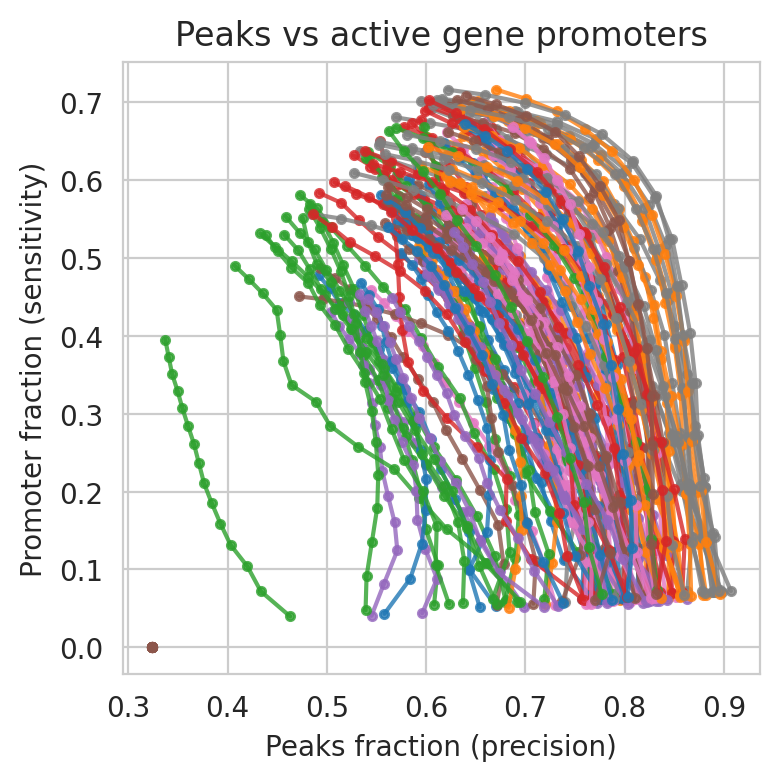

In [23]:
print('ENCODE')
plt.figure(figsize=(4, 4))
for (c, r, t), dft in encode_cpf_df.groupby(['cell', 'replicate', 'tool']):    
    plt.plot(dft['precision'], dft['sensitivity'], marker='.', color=TOOLS_PALETTE[t], alpha=0.8)
plt.title('Peaks vs active gene promoters')
plt.xlabel('Peaks fraction (precision)')
plt.ylabel('Promoter fraction (sensitivity)')
plt.tight_layout()
plt.show()

ENCODE


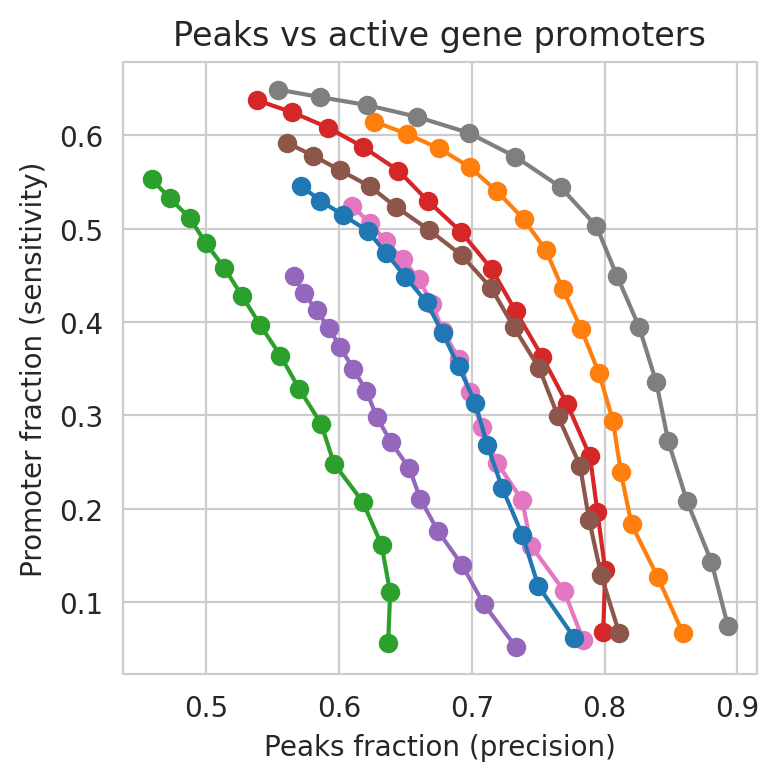

In [24]:
print('ENCODE')
plt.figure(figsize=(4, 4))
cr = encode_cpf_df[(encode_cpf_df['cell'] == 'K562') & (encode_cpf_df['replicate'] == 'rep1')]
for (c, r, t), dft in cr.groupby(['cell', 'replicate', 'tool']):
    plt.plot(dft['precision'], dft['sensitivity'], marker='o', color=TOOLS_PALETTE[t], alpha=1)
plt.title('Peaks vs active gene promoters')
plt.xlabel('Peaks fraction (precision)')
plt.ylabel('Promoter fraction (sensitivity)')
plt.tight_layout()
plt.show()

Roadmap


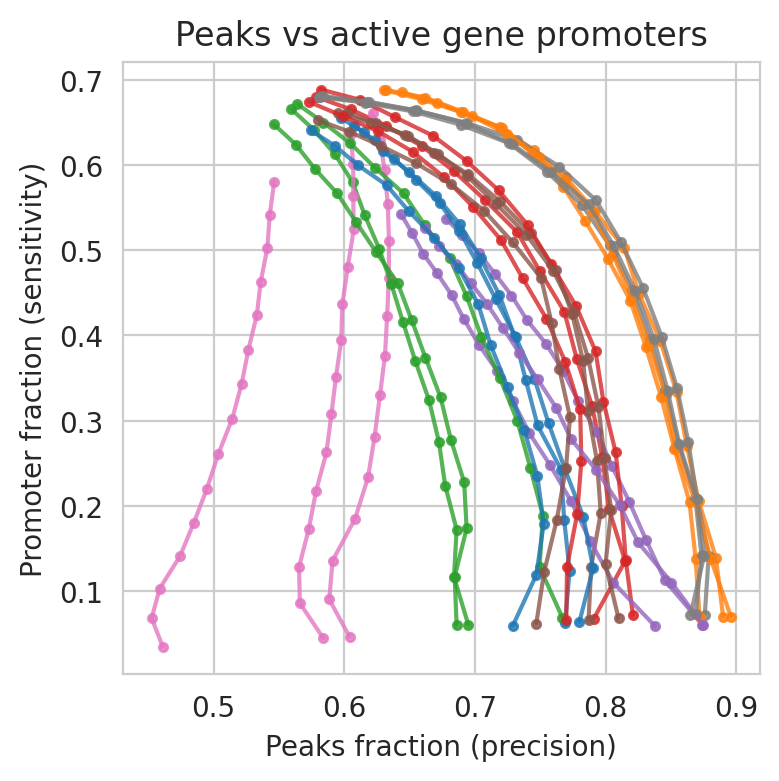

In [25]:
print('Roadmap')
plt.figure(figsize=(4, 4))
for (c, r, t), dft in immune_cpf_df.groupby(['cell', 'replicate', 'tool']):
    plt.plot(dft['precision'], dft['sensitivity'], marker='.', color=TOOLS_PALETTE[t], alpha=0.8)
plt.title('Peaks vs active gene promoters')
plt.xlabel('Peaks fraction (precision)')
plt.ylabel('Promoter fraction (sensitivity)')
plt.tight_layout()
plt.show()

Immune


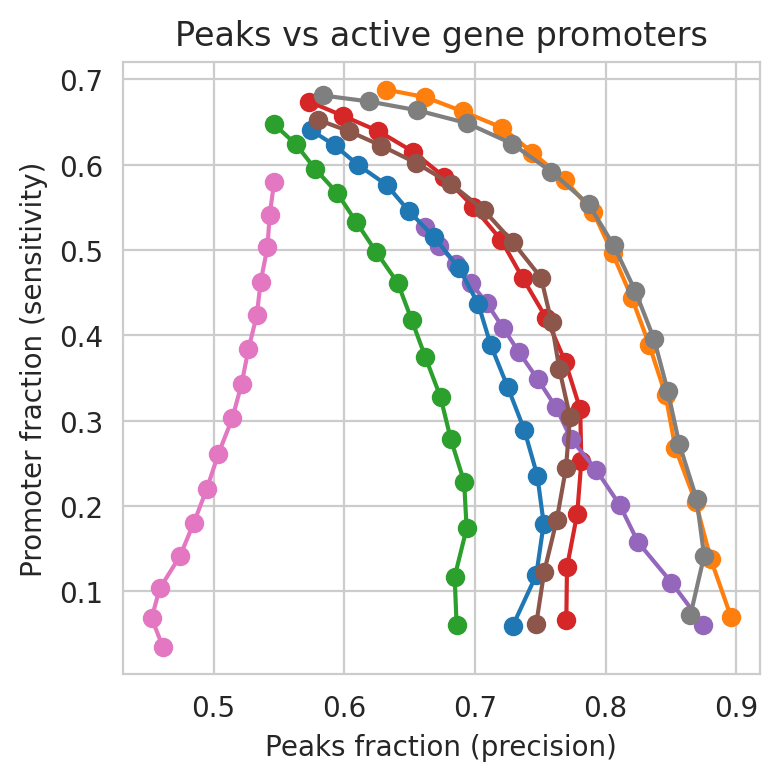

In [26]:
print('Immune')
plt.figure(figsize=(4, 4))
cr = immune_cpf_df[immune_cpf_df['cell'] == 'TCell']
for (c, r, t), dft in cr.groupby(['cell', 'replicate', 'tool']):
    plt.plot(dft['precision'], dft['sensitivity'], marker='o', color=TOOLS_PALETTE[t], alpha=1)
plt.title('Peaks vs active gene promoters')
plt.xlabel('Peaks fraction (precision)')
plt.ylabel('Promoter fraction (sensitivity)')
plt.tight_layout()
plt.show()

ENCODE + Roadmap


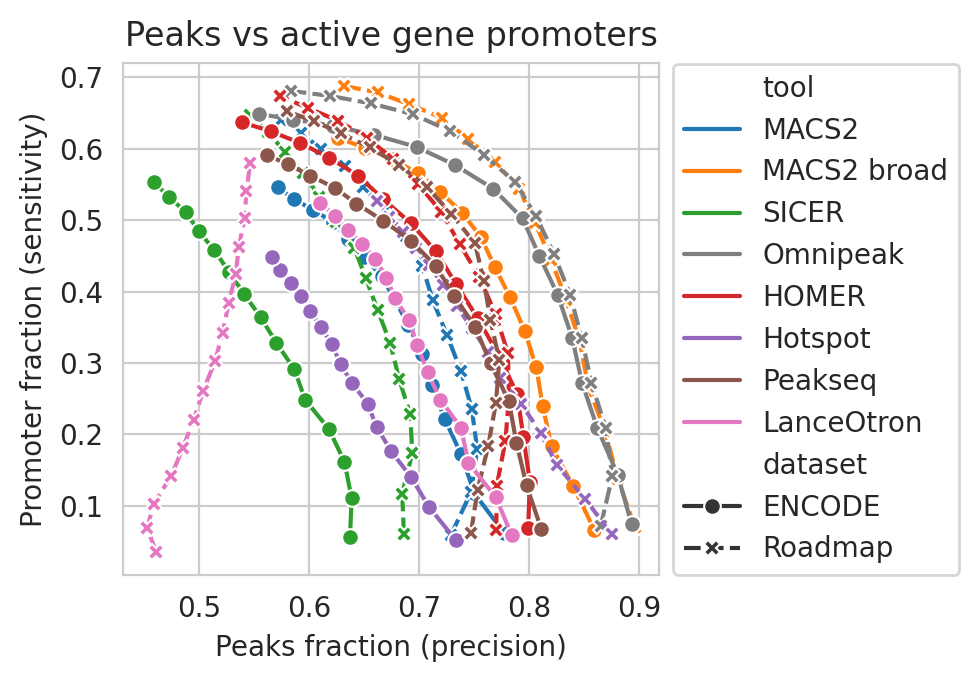

In [27]:
print('ENCODE + Roadmap')
plt.figure(figsize=(5, 3.5))
t1 = encode_cpf_df[(encode_cpf_df['cell'] == 'K562') & (encode_cpf_df['replicate'] == 'rep1')].copy()
t1['dataset'] = 'ENCODE'
t2 = immune_cpf_df[immune_cpf_df['cell'] == 'TCell'].copy()
t2['dataset'] = 'Roadmap'
cr = pd.concat([t1, t2]).reset_index(drop=True)
ax = plt.axes()
sns.lineplot(
    data=cr,
    x='precision', y='sensitivity', style='dataset',
    hue='tool',
    markers=True, sort=False,
    palette=TOOLS_PALETTE,
    ax=ax
)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Peaks vs active gene promoters')
plt.xlabel('Peaks fraction (precision)')
plt.ylabel('Promoter fraction (sensitivity)')
plt.tight_layout()
plt.show()

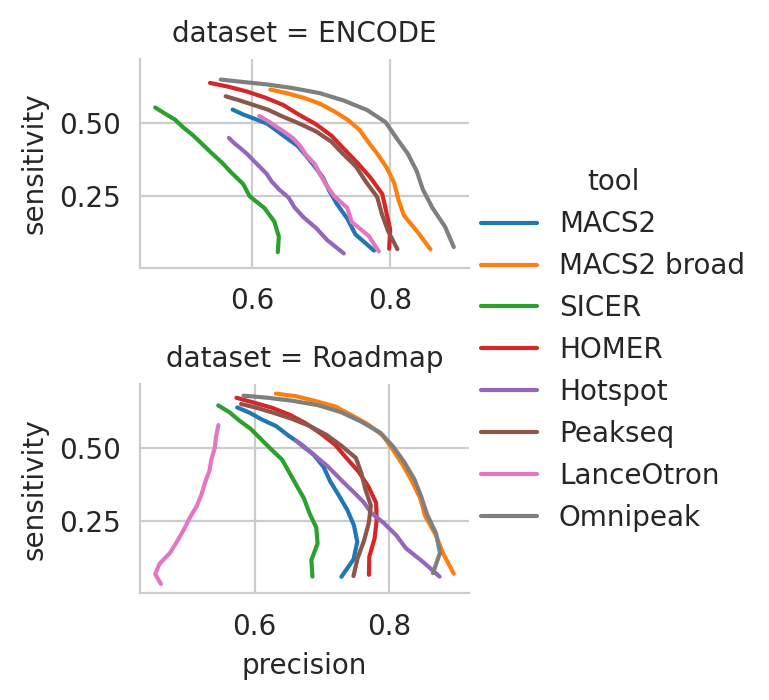

In [28]:
g = sns.FacetGrid(cr, hue="tool", row="dataset", height=1.8, aspect=1.5, palette=TOOLS_PALETTE, 
                  hue_order=TOOLS, sharex=False)
g.map(sns.lineplot, "precision", "sensitivity", sort=False)
g.add_legend()
plt.show()

## Average precision

AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:

AP = ∑(Rn−Rn−1)*Pn, where  Pn and Rn are the precision and recall at the nth threshold.

This implementation is not interpolated and is different from computing the area under the precision-recall curve with the trapezoidal rule, which uses linear interpolation and can be too optimistic.

In [29]:
rows = []
for (c, r, t), dft in encode_cpf_df.groupby(['cell', 'replicate', 'tool']):
    ap = 0
    sprev, pprev = None, None
    for _, row in dft.iterrows():
        if sprev is not None and pprev is not None:
            ap += (row['sensitivity'] - sprev) * (row['precision'] + pprev) / 2
        sprev, pprev = row['sensitivity'], row['precision']
    rows.append((c, r, t, ap))
encode_aps_df = pd.DataFrame(rows, columns=['cell', 'replicate', 'tool', 'auc'])
del rows
encode_aps_df.sample(3)

,cell,replicate,tool,auc
69,HepG2,rep2,Omnipeak,0.515578
122,NHLF,rep2,LanceOtron,0.470631
46,HMEC,rep2,Peakseq,0.312580


ENCODE


/tmp/ipykernel_785283/1256165316.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=encode_aps_df, x='tool', y='auc',


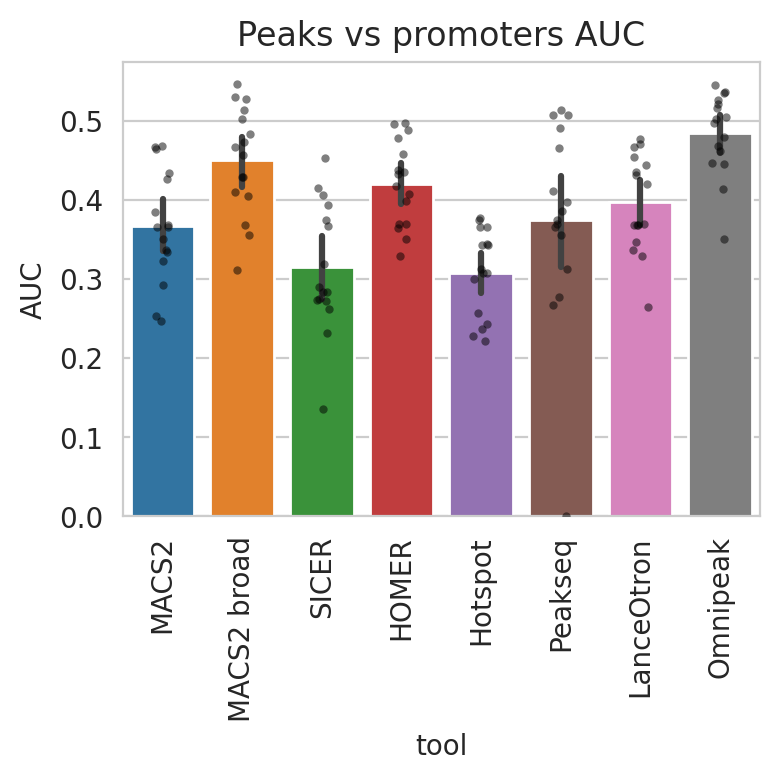

In [30]:
print('ENCODE')
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Peaks vs promoters AUC')
sns.barplot(data=encode_aps_df, x='tool', y='auc',
            # capsize=.2, err_kws={'linewidth': 2},
            # legend=False,
            palette=TOOLS_PALETTE,
            order=TOOLS,
            ax=ax)
sns.stripplot(data=encode_aps_df, x='tool', y='auc',
              dodge=True, size=3, color="black", alpha=0.5,
              legend=False,
              order=TOOLS,
              ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('AUC')
plt.tight_layout()
plt.show()

In [31]:
rows = []
for (c, r, t), dft in immune_cpf_df.groupby(['cell', 'replicate', 'tool']):
    ap = 0
    sprev, pprev = None, None
    for _, row in dft.iterrows():
        if sprev is not None and pprev is not None:
            ap += (row['sensitivity'] - sprev) * (row['precision'] + pprev) / 2
        sprev, pprev = row['sensitivity'], row['precision']
    rows.append((c, r, t, ap))
immune_aps_df = pd.DataFrame(rows, columns=['cell', 'replicate', 'tool', 'auc'])
del rows
immune_aps_df.sample(3)

,cell,replicate,tool,auc
1,BCell,,Hotspot,0.372689
8,Monocyte,,HOMER,0.472537
18,TCell,,LanceOtron,0.276553


Roadmap


/tmp/ipykernel_785283/1197663385.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=immune_aps_df, x='tool', y='auc',


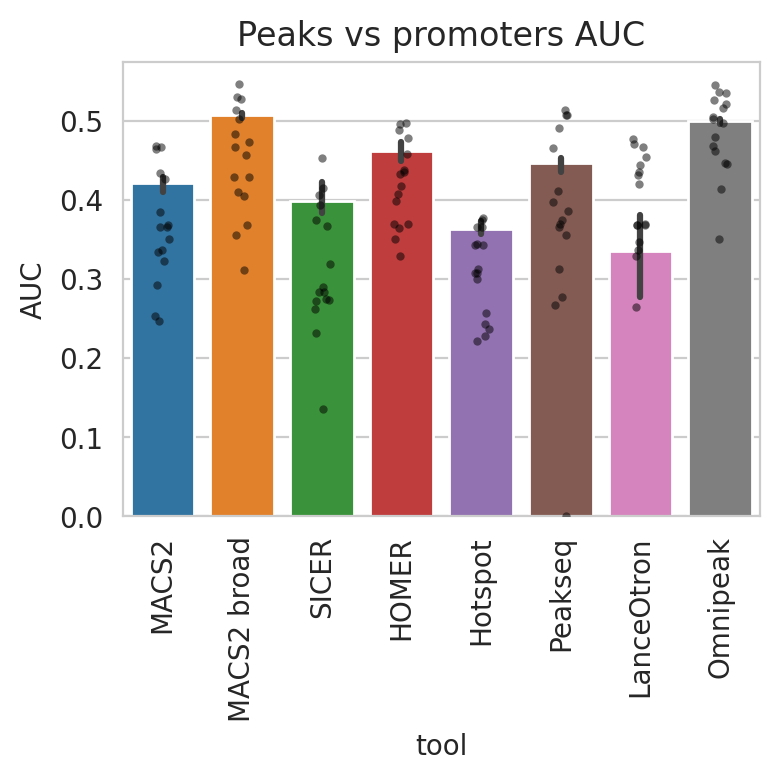

In [32]:
print('Roadmap')
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Peaks vs promoters AUC')
sns.barplot(data=immune_aps_df, x='tool', y='auc',
            # capsize=.2, err_kws={'linewidth': 2},
            palette=TOOLS_PALETTE,
            order=TOOLS,
            ax=ax)
sns.stripplot(data=encode_aps_df, x='tool', y='auc',
              dodge=True, size=3, color="black", alpha=0.5,
              order=TOOLS,
              ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('AUC')
plt.tight_layout()
plt.show()

Roadmap + ENCODE


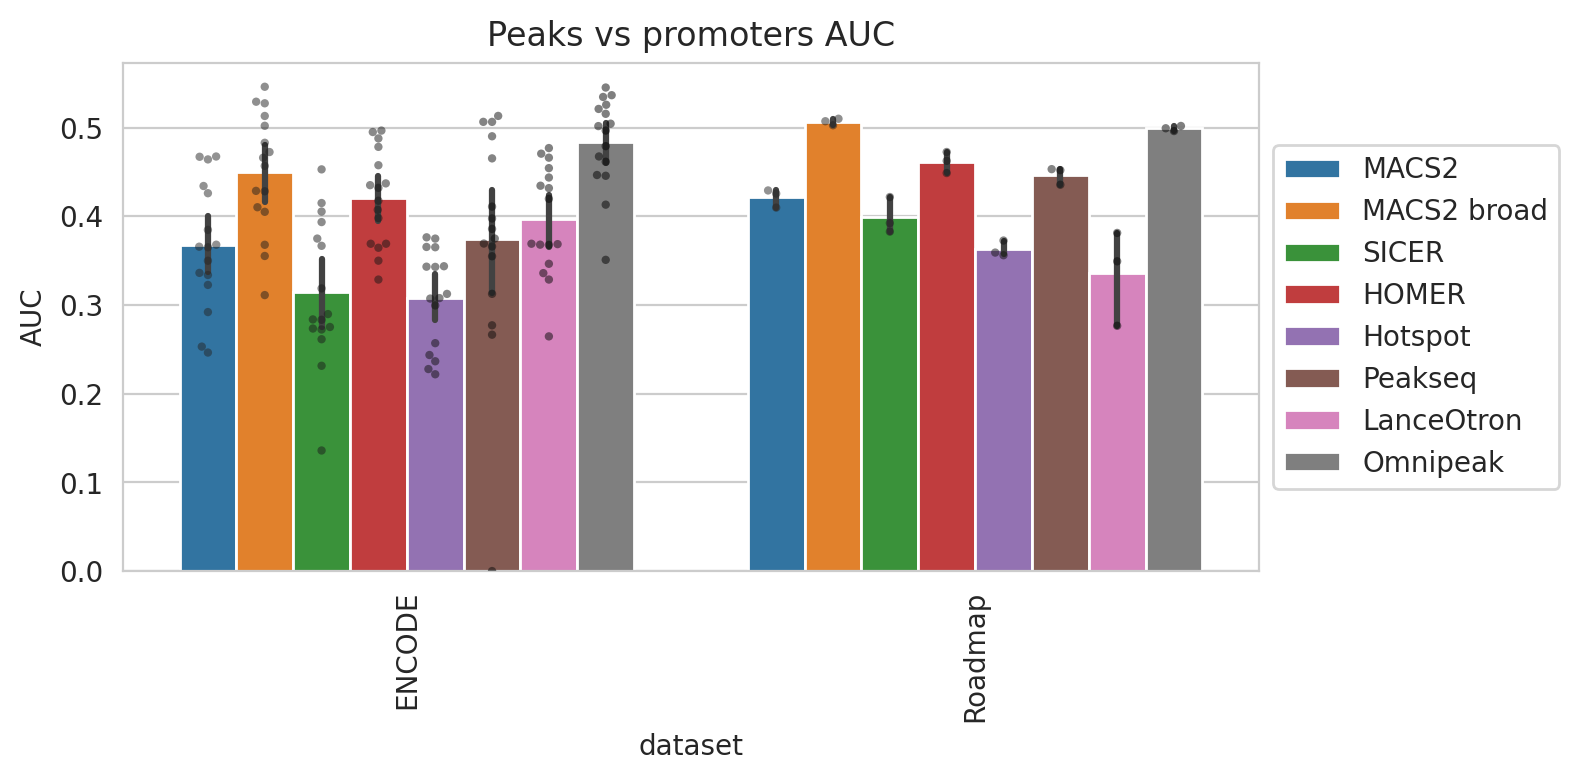

In [33]:
print('Roadmap + ENCODE')
encode_aps_df['dataset'] = 'ENCODE'
immune_aps_df['dataset'] = 'Roadmap'
t = pd.concat([encode_aps_df, immune_aps_df]).reset_index(drop=True)
plt.figure(figsize=(8, 4))
ax = plt.axes()
ax.title.set_text('Peaks vs promoters AUC')
sns.barplot(data=t, x='dataset', y='auc', hue='tool',
            # capsize=.2, err_kws={'linewidth': 2},
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            ax=ax)
sns.swarmplot(data=t, x='dataset', y='auc', hue='tool',
              dodge=True, size=3, color="black", alpha=0.5, palette='dark:black',
              hue_order=TOOLS,
              legend=False,
              ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('AUC')
plt.tight_layout()
plt.show()

# Jaccard H3K36me3 vs expressed genes bodies

In [34]:
def genes_overlap(df_peaks, expression):
    rows = []
    for _, (c, r, tool, file) in tqdm(list(df_peaks[df_peaks['modification'] == 'H3K36me3']
                                      [['cell', 'replicate', 'tool', 'file']].iterrows())):
        # print(c, r, tool, file)
        if (c, r) not in expression:
            continue
        genes_file = pr.read_bed(sorted_file(expression[c, r]))
        genes = len(genes_file)
        genes_len = genes_file.lengths().sum()
        peaks = lines(file)
        if peaks == 0:
            rows.append((c, r, tool, 0, 0, genes, genes_len, 0, 0, 0))
            continue
        peaks_file = pr.read_bed(sorted_file(file))
        peaks_len = bedl(peaks_file).sum()
        peaks_overlap = len(peaks_file.overlap(genes_file)) 
        genes_overlap = len(genes_file.overlap(peaks_file))
        overlap_len = peaks_file.intersect(genes_file).lengths().sum()
        rows.append((c, r, tool, 
                     peaks, peaks_len, genes, genes_len,
                     peaks_overlap, genes_overlap, overlap_len))

    df = pd.DataFrame(
        rows,
        columns=['cell', 'replicate', 'tool',
                 'peaks', 'peaks_len', 'genes', 'genes_len',
                 'peaks_overlap', 'genes_overlap', 'overlap_len'],
        dtype=object
    )
    df['precision'] = [d(a, b) for a, b in zip(df['peaks_overlap'], df['peaks'])]
    df['sensitivity'] = [d(a, b) for a, b in zip(df['genes_overlap'], df['genes'])]
    df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                      for s, p in zip(df['sensitivity'], df['precision'])]

    df['jaccard'] = [
        d(o, p + g -o)
        for p, g, o in zip(df['peaks_len'], df['genes_len'], df['overlap_len'])
    ]
    return df

In [35]:
encode_genes_df = genes_overlap(df_encode_peaks, encode_expression)
encode_genes_df.sample(3)

  0%|          | 0/136 [00:00<?, ?it/s]

,cell,replicate,tool,peaks,peaks_len,genes,genes_len,peaks_overlap,genes_overlap,overlap_len,precision,sensitivity,f1,jaccard
126,HepG2,rep1,LanceOtron,404631,0.0,14945,802734940,311280,12322,158344619,0.769294,0.824490,0.795936,0.245728
122,Huvec,rep1,LanceOtron,378690,0.0,14995,885905190,267605,12690,131469171,0.706660,0.846282,0.770194,0.174262
107,Huvec,rep1,Peakseq,18521,0.0,14995,885905190,18027,5603,5062728,0.973328,0.373658,0.540008,0.005748


ENCODE


/tmp/ipykernel_785283/3534923998.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=encode_genes_df, x='tool', y='jaccard',


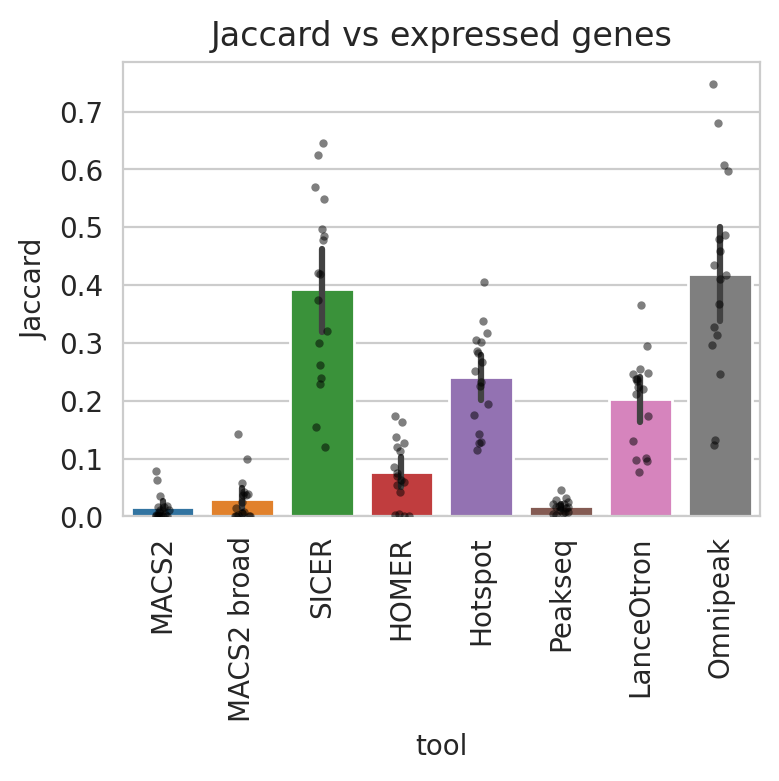

In [36]:
print('ENCODE')
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Jaccard vs expressed genes')
sns.barplot(data=encode_genes_df, x='tool', y='jaccard',
            # capsize=.2, err_kws={'linewidth': 2},
            palette=TOOLS_PALETTE,
            order=TOOLS,
            ax=ax,)
sns.stripplot(data=encode_genes_df, x='tool', y='jaccard',
              dodge=True, size=3, color="black", alpha=0.5,
              order=TOOLS,
              ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Jaccard')
plt.tight_layout()
plt.show()

In [37]:
immune_genes_df = genes_overlap(df_immune_peaks, immune_expression)
immune_genes_df.sample(3)

  0%|          | 0/64 [00:00<?, ?it/s]

,cell,replicate,tool,peaks,peaks_len,genes,genes_len,peaks_overlap,genes_overlap,overlap_len,precision,sensitivity,f1,jaccard
21,BCell,,LanceOtron,258487,0.0,14977,814323277,243516,11361,174385234,0.942082,0.758563,0.840421,0.272503
10,TCell,,Omnipeak,29596,0.0,14974,775408501,27338,12496,374140154,0.923706,0.834513,0.876847,0.932394
7,TCell,,SICER,32491,0.0,14974,775408501,31502,11852,342899508,0.969561,0.791505,0.871532,0.792815


Roadmap


/tmp/ipykernel_785283/941193859.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=immune_genes_df, x='tool', y='jaccard',


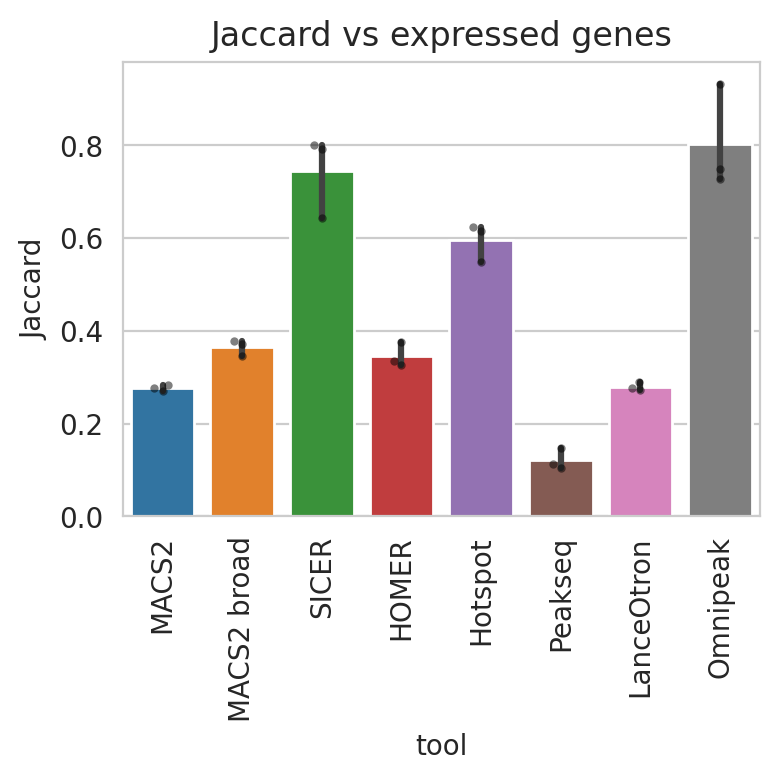

In [38]:
print('Roadmap')
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Jaccard vs expressed genes')
sns.barplot(data=immune_genes_df, x='tool', y='jaccard',
            # capsize=.2, err_kws={'linewidth': 2},
            palette=TOOLS_PALETTE,
            order=TOOLS,
            ax=ax)
sns.swarmplot(data=immune_genes_df, x='tool', y='jaccard',
              dodge=True, size=3, color="black", alpha=0.5,
              order=TOOLS,
              ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Jaccard')
plt.tight_layout()
plt.show()

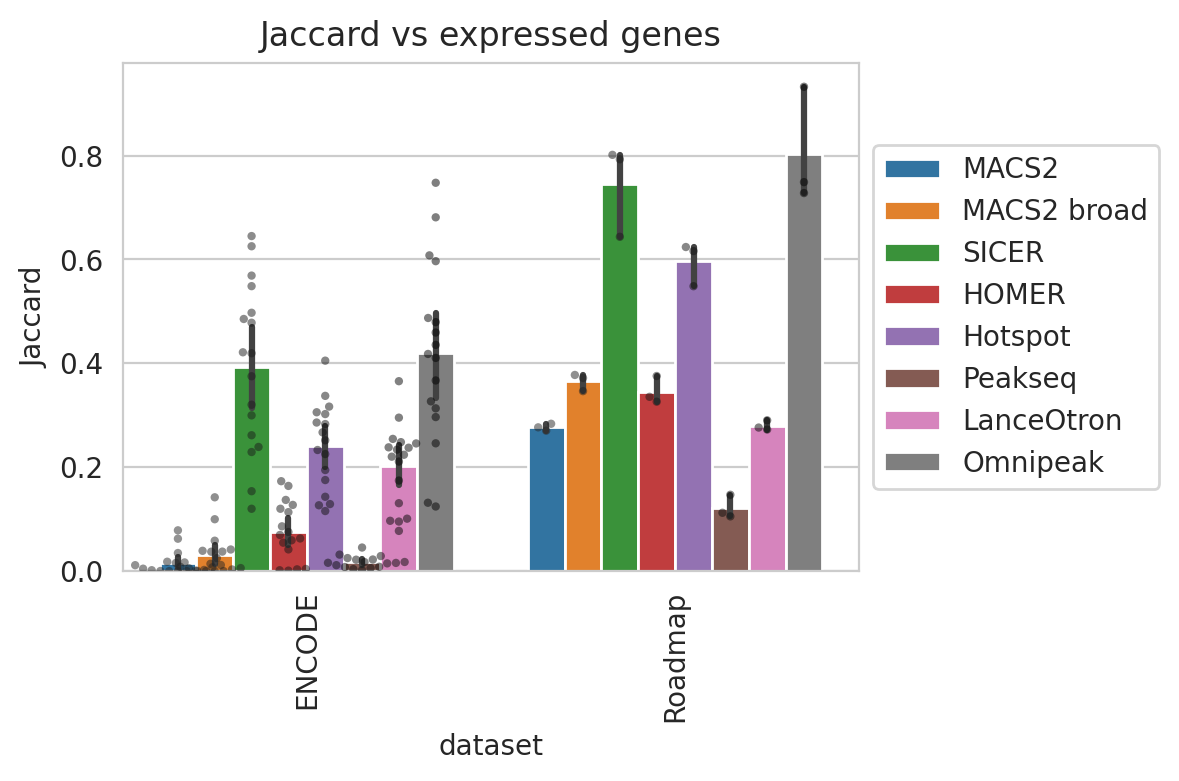

In [39]:
encode_genes_df['dataset'] = 'ENCODE'
immune_genes_df['dataset'] = 'Roadmap'
t = pd.concat([encode_genes_df, immune_genes_df]).reset_index(drop=True)
plt.figure(figsize=(6, 4))
ax = plt.axes()
ax.title.set_text('Jaccard vs expressed genes')
sns.barplot(data=t, x='dataset', y='jaccard', hue='tool',
            # capsize=0.2, err_kws={'linewidth': 2},
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            ax=ax)
sns.swarmplot(data=t, x='dataset', y='jaccard', hue='tool',
              dodge=True, size=3, color="black", alpha=0.5, palette='dark:black',
              hue_order=TOOLS, legend=False,
              ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Jaccard')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

## Compare ratio of peaks to genes

In [40]:
import tempfile

def genes_peaks_ratio(df_peaks, expression):
    tf = tempfile.mktemp()

    rows = []
    for _, (c, r, tool, file) in tqdm(list(df_peaks[df_peaks['modification'] == 'H3K36me3']
                                      [['cell', 'replicate', 'tool', 'file']].iterrows())):
        # print(c, r, tool, file)
        if (c, r) not in expression:
            continue
        genes_file = sorted_file(expression[c, r])
        peaks_file = sorted_file(file)
        ! echo "" > {tf}
        ! bedtools intersect -a {genes_file} -b {peaks_file} -wa -wb > {tf}
        expr_cols = len(pd.read_csv(genes_file, sep='\t', header=None, nrows=1).columns)
        try:
            tf_expression = pd.read_csv(tf, sep='\t', header=None)
            genes = len(tf_expression.groupby([0, 1, 2]).count())
            peaks = len(tf_expression.groupby([expr_cols, expr_cols + 1, expr_cols + 2]).count())
            rows.append((c, r, tool, genes, peaks))
        except:
            pass
        ! rm {genes_file} {peaks_file} {tf}

    df = pd.DataFrame(
        rows,
        columns=['cell', 'replicate', 'tool', 'genes', 'peaks'],
        dtype=object
    )
    df['peaks_to_genes'] = df['peaks'] / df['genes']
    return df

In [41]:
encode_genes_ratios = genes_peaks_ratio(df_encode_peaks, encode_expression)
encode_genes_ratios.sample(3)

  0%|          | 0/136 [00:00<?, ?it/s]

,cell,replicate,tool,genes,peaks,peaks_to_genes
5,NHLF,rep2,MACS2,10412,98238,9.435075
80,H1,rep1,Hotspot,12082,172117,14.245737
87,Huvec,rep2,Hotspot,11853,256661,21.653674


ENCODE


/tmp/ipykernel_785283/364604186.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=encode_genes_ratios, y='peaks_to_genes', x='tool',


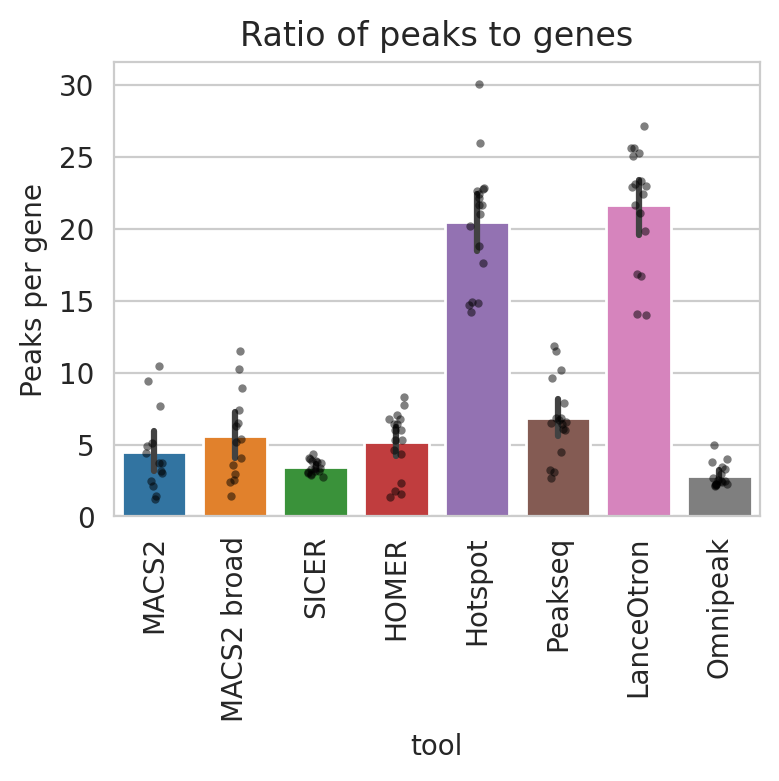

In [42]:
print('ENCODE')
plt.figure(figsize=(4, 4))
ax = plt.axes()
sns.barplot(data=encode_genes_ratios, y='peaks_to_genes', x='tool', 
            # capsize=.2, err_kws={'linewidth': 2},
            palette=TOOLS_PALETTE,
            order=TOOLS,
            ax=ax)
sns.stripplot(data=encode_genes_ratios, y='peaks_to_genes', x='tool',
              dodge=True, size=3, color="black", alpha=0.5,
              order=TOOLS,
              ax=ax)
ax.set_ylabel('Peaks per gene')
ax.title.set_text('Ratio of peaks to genes')
ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.show()

In [43]:
immune_genes_ratios = genes_peaks_ratio(df_immune_peaks, immune_expression)
immune_genes_ratios.sample(3)

  0%|          | 0/64 [00:00<?, ?it/s]

,cell,replicate,tool,genes,peaks,peaks_to_genes
4,BCell,,MACS2 broad,11695,145473,12.438906
10,TCell,,Omnipeak,12496,27338,2.18774
16,TCell,,Hotspot,12701,355239,27.969372


Immune


/tmp/ipykernel_785283/2663489381.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=immune_genes_ratios, y='peaks_to_genes', x='tool',


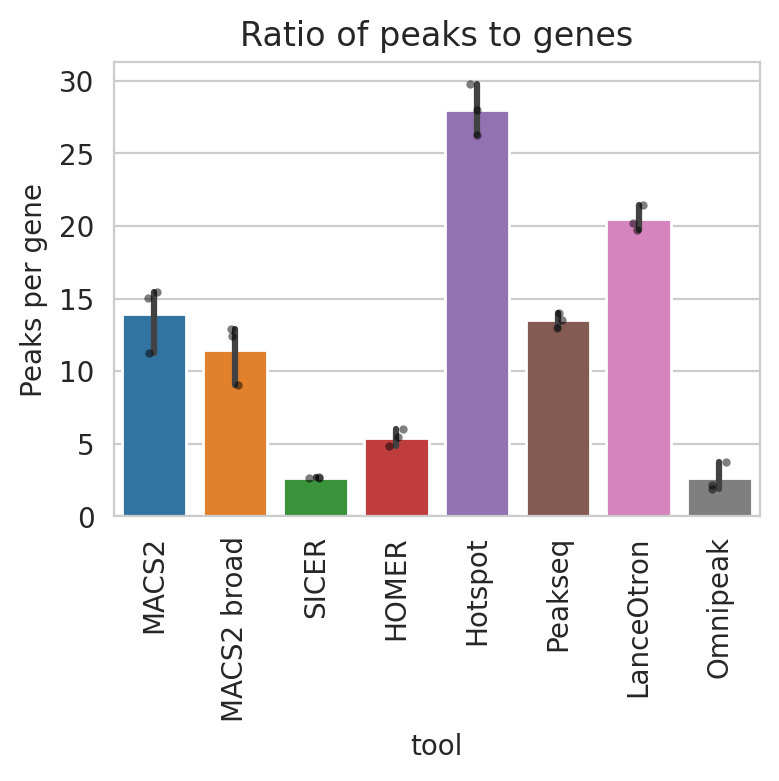

In [44]:
print('Immune')
plt.figure(figsize=(4, 4))
ax = plt.axes()
sns.barplot(data=immune_genes_ratios, y='peaks_to_genes', x='tool',
            # capsize=.2, err_kws={'linewidth': 2},
            palette=TOOLS_PALETTE,
            order=TOOLS,
            ax=ax)
sns.stripplot(data=immune_genes_ratios, y='peaks_to_genes', x='tool',
              dodge=True, size=3, color="black", alpha=0.5,
              order=TOOLS,
              ax=ax)
ax.set_ylabel('Peaks per gene')
ax.title.set_text('Ratio of peaks to genes')
ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.show()

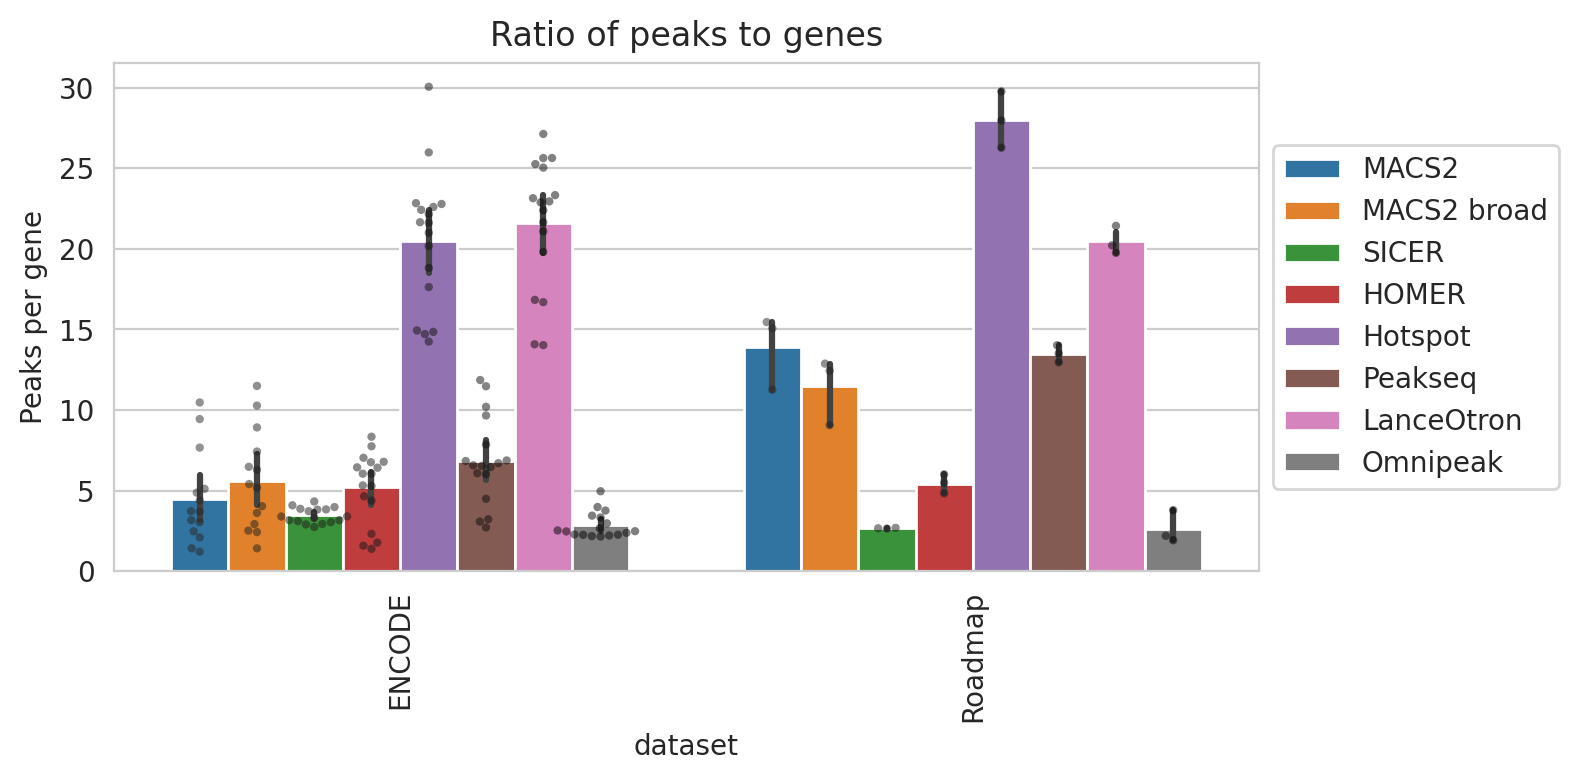

In [45]:
encode_genes_ratios['dataset'] = 'ENCODE'
immune_genes_ratios['dataset'] = 'Roadmap'
t = pd.concat([encode_genes_ratios, immune_genes_ratios]).reset_index(drop=True)
plt.figure(figsize=(8, 4))
ax = plt.axes()
sns.barplot(data=t, y='peaks_to_genes', x='dataset', hue='tool',
            # capsize=.2, err_kws={'linewidth': 2},
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            ax=ax)
sns.swarmplot(data=t, y='peaks_to_genes', x='dataset', hue='tool',
              dodge=True, size=3, color="black", alpha=0.5, palette='dark:black',
              hue_order=TOOLS, legend=False,
              ax=ax)
ax.set_ylabel('Peaks per gene')
ax.title.set_text('Ratio of peaks to genes')
ax.xaxis.set_tick_params(rotation=90)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# H3K36me3 overlap vs genes benchmark

In [46]:
def genes_overlap(df_peaks, expression_genes):

    rows = []
    for _, (c, r, tool, file) in tqdm(list(df_peaks[df_peaks['modification'] == 'H3K36me3']
                                           [['cell', 'replicate', 'tool', 'file']].iterrows())):
        # print(c, r, tool, file)
        if (c, r) not in expression_genes:
            continue
        genes_file = pr.read_bed(sorted_file(expression_genes[c, r]))
        genes = len(genes_file)
        if lines(file) == 0:
            for top in np.linspace(1000, 15000, 15):
                rows.append((c, r, top, genes, file, 0, 0, 0, tool))
            continue
        peaks_file = pr.read_bed(sorted_file(file), as_df=True)
        if len(peaks_file.columns) == 10: # Peakseq
            sort_col = peaks_file.columns[9]
        elif len(peaks_file.columns) >= 9:
            sort_col = peaks_file.columns[8]
        else:
            sort_col = peaks_file.columns[4]
        peaks_file.sort_values(
            by=sort_col,
            ascending=False, inplace=True
        )
        for top in np.linspace(1000, 15000, 15):
            t = PyRanges(peaks_file.head(int(top)).sort_values(by=['Chromosome', 'Start']))
            peaks = len(t)
            peaks_overlap = len(t.overlap(genes_file))
            tss_overlap = len(genes_file.overlap(t))
            rows.append((c, r, top, genes, file, peaks, peaks_overlap, tss_overlap, tool))

    df = pd.DataFrame(
        rows,
        columns=['cell', 'replicate', 'top', 'genes', 'peaks_file', 'peaks', 'pg', 'gp', 'tool'],
        dtype=object
    )
    df['p'] = (df['pg'] + df['gp']) / 2
    df['precision'] = [d(x, y) for x, y in zip(df['pg'], df['peaks'])]
    df['sensitivity'] = [d(x, y) for x, y in zip(df['gp'], df['genes'])]
    df['f1'] = [
        2 / (d(1, s + 1e-10) + d(1, p + 1e-10))
        for s, p in zip(df['sensitivity'], df['precision'])]
    return df

In [47]:
encode_genes_ovlp_df = genes_overlap(df_encode_peaks, encode_expression)
encode_genes_ovlp_df.sample(3)

  0%|          | 0/136 [00:00<?, ?it/s]

,cell,replicate,top,genes,peaks_file,peaks,pg,gp,tool,p,precision,sensitivity,f1
340,HMEC,rep2,11000.0,14969,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,11000,10808,4949,MACS2 broad,7878.5,0.982545,0.330617,0.494754
49,NHEK,rep2,5000.0,14981,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,5000,4879,2659,MACS2,3769.0,0.975800,0.177491,0.300351
201,GM12878,rep1,7000.0,14934,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,1741,1707,1206,MACS2,1456.5,0.980471,0.080755,0.149220


ENCODE


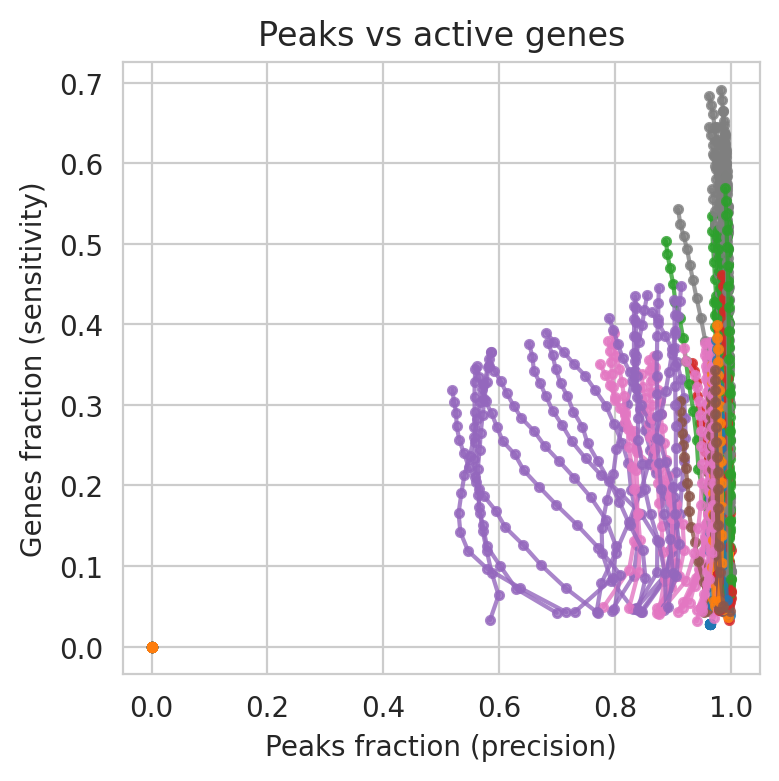

In [48]:
print('ENCODE')
plt.figure(figsize=(4, 4))
for (c, r, t), dft in encode_genes_ovlp_df.groupby(['cell', 'replicate', 'tool']):
    plt.plot(dft['precision'], dft['sensitivity'], marker='.', color=TOOLS_PALETTE[t], alpha=0.8)
plt.title('Peaks vs active genes')
plt.xlabel('Peaks fraction (precision)')
plt.ylabel('Genes fraction (sensitivity)')
plt.tight_layout()
plt.show()

In [49]:
encode_genes_ovlp_df[(encode_genes_ovlp_df['sensitivity'] > 0.7) & 
                     (encode_genes_ovlp_df['precision'] < 0.99)]

,cell,replicate,top,genes,peaks_file,peaks,pg,gp,tool,p,precision,sensitivity,f1


ENCODE


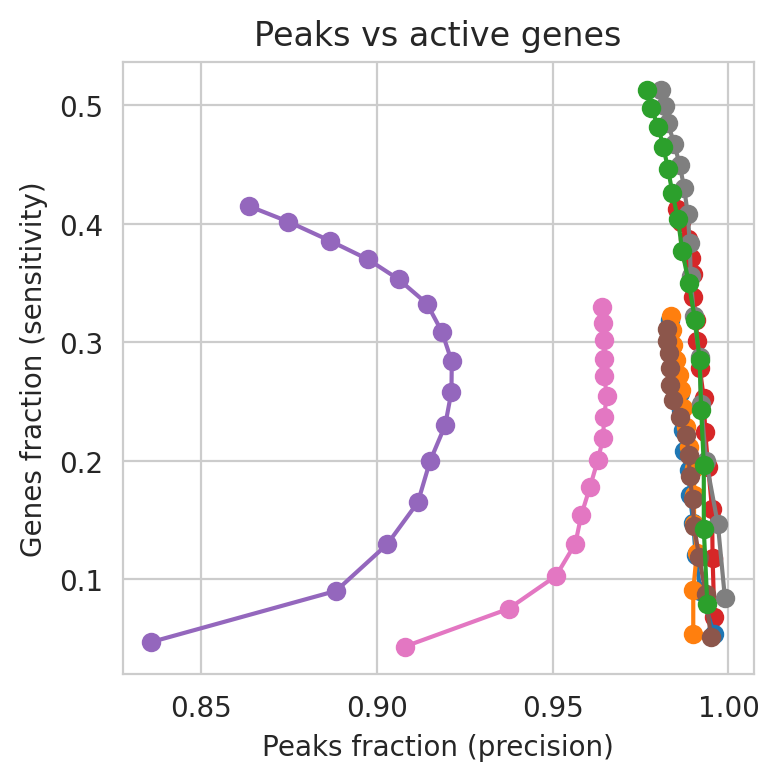

In [50]:
print('ENCODE')
plt.figure(figsize=(4, 4))
cr = encode_genes_ovlp_df[(encode_genes_ovlp_df['cell'] == 'H1') &
                          (encode_genes_ovlp_df['replicate'] == 'rep1')]
for (c, r, t), dft in cr.groupby(['cell', 'replicate', 'tool']):
    plt.plot(dft['precision'], dft['sensitivity'], marker='o', color=TOOLS_PALETTE[t], alpha=1.0)
plt.title('Peaks vs active genes')
plt.xlabel('Peaks fraction (precision)')
plt.ylabel('Genes fraction (sensitivity)')
plt.tight_layout()
plt.show()

In [51]:
rows = []
for (c, r, t), dft in encode_genes_ovlp_df.groupby(['cell', 'replicate', 'tool']):
    ap = 0
    sprev, pprev = None, None
    for _, row in dft.iterrows():
        if sprev is not None and pprev is not None:
            ap += (row['sensitivity'] - sprev) * (row['precision'] + pprev) / 2
        sprev, pprev = row['sensitivity'], row['precision']
    rows.append((c, r, t, ap))
encode_genes_aps_df = pd.DataFrame(rows, columns=['cell', 'replicate', 'tool', 'auc'])
del rows
encode_genes_aps_df.sample(3)

,cell,replicate,tool,auc
32,HMEC,rep1,HOMER,0.102278
123,NHLF,rep1,MACS2,0.000000
36,HMEC,rep1,MACS2 broad,0.000000


ENCODE


/tmp/ipykernel_785283/1115513193.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g_results = sns.barplot(data=encode_genes_aps_df, x='tool', y='auc',


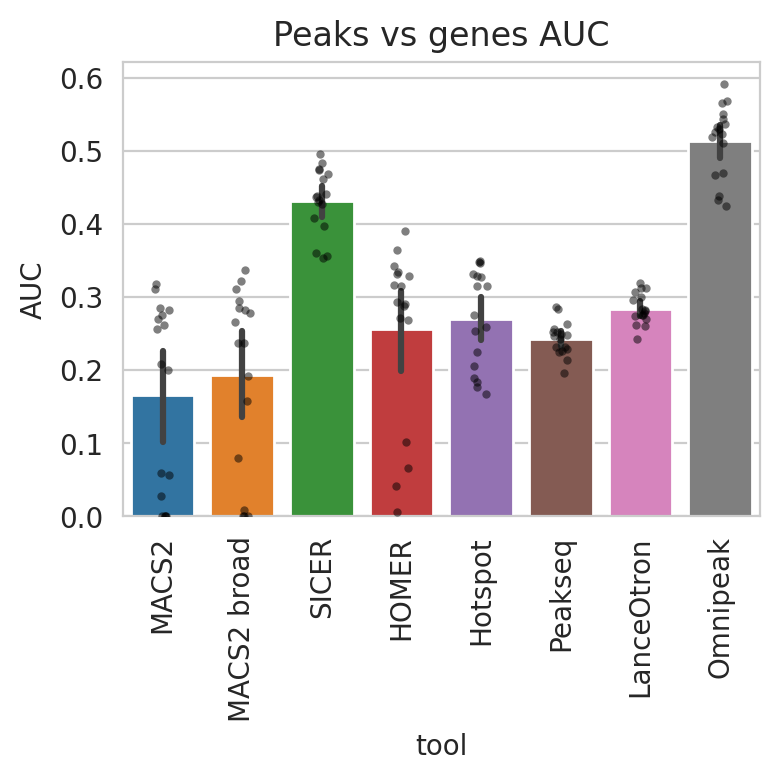

In [52]:
print('ENCODE')
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Peaks vs genes AUC')
g_results = sns.barplot(data=encode_genes_aps_df, x='tool', y='auc',
                        # capsize=.2, err_kws={'linewidth': 2},
                        palette=TOOLS_PALETTE,
                        order=TOOLS,
                        ax=ax)
sns.stripplot(data=encode_genes_aps_df, x='tool', y='auc',
              dodge=True, size=3, color="black", alpha=0.5,
              order=TOOLS,
              ax=ax)

ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('AUC')
plt.tight_layout()
plt.show()

In [53]:
immune_genes_ovlp_df = genes_overlap(df_immune_peaks, immune_expression)
immune_genes_ovlp_df.sample(3)

  0%|          | 0/64 [00:00<?, ?it/s]

,cell,replicate,top,genes,peaks_file,peaks,pg,gp,tool,p,precision,sensitivity,f1
331,Monocyte,,2000.0,14986,/home/jetbrains/data/2023_Immune/lanceotron/Mo...,2000,1981,1349,LanceOtron,1665.0,0.990500,0.090017,0.165036
356,TCell,,12000.0,14974,/home/jetbrains/data/2023_Immune/lanceotron/TC...,12000,11872,4100,LanceOtron,7986.0,0.989333,0.273808,0.428911
226,Monocyte,,2000.0,14986,/home/jetbrains/data/2023_Immune/hotspot/Monoc...,2000,1917,1275,Hotspot,1596.0,0.958500,0.085079,0.156286


Immune


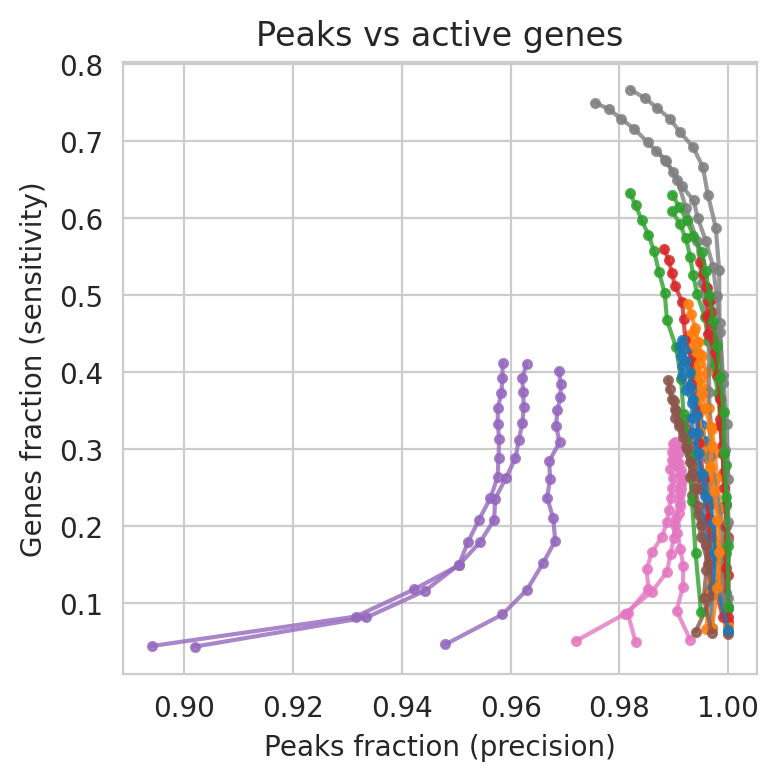

In [54]:
print('Immune')
plt.figure(figsize=(4, 4))
for (c, r, t), dft in immune_genes_ovlp_df.groupby(['cell', 'replicate', 'tool']):
    plt.plot(dft['precision'], dft['sensitivity'], marker='.', color=TOOLS_PALETTE[t], alpha=0.8)
plt.title('Peaks vs active genes')
plt.xlabel('Peaks fraction (precision)')
plt.ylabel('Genes fraction (sensitivity)')
plt.tight_layout()
plt.show()

Immune


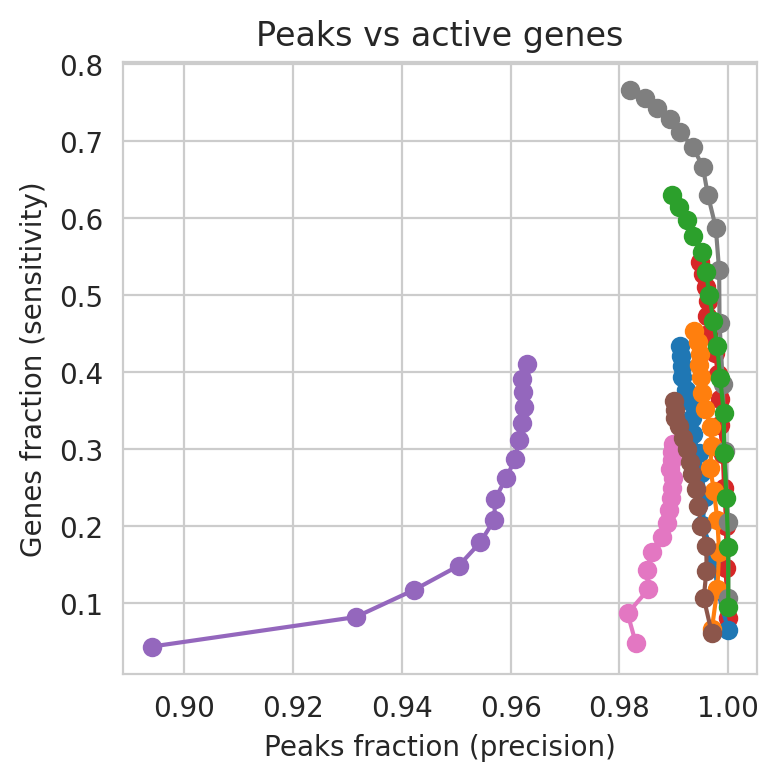

In [55]:
print('Immune')
plt.figure(figsize=(4, 4))
cr = immune_genes_ovlp_df[immune_genes_ovlp_df['cell'] == 'TCell']
for (c, r, t), dft in cr.groupby(['cell', 'replicate', 'tool']):
    plt.plot(dft['precision'], dft['sensitivity'], marker='o', color=TOOLS_PALETTE[t], alpha=1.0)
plt.title('Peaks vs active genes')
plt.xlabel('Peaks fraction (precision)')
plt.ylabel('Genes fraction (sensitivity)')
plt.tight_layout()
plt.show()

In [56]:
rows = []
for (c, r, t), dft in immune_genes_ovlp_df.groupby(['cell', 'replicate', 'tool']):
    ap = 0
    sprev, pprev = None, None
    for _, row in dft.iterrows():
        if sprev is not None and pprev is not None:
            ap += (row['sensitivity'] - sprev) * (row['precision'] + pprev) / 2
        sprev, pprev = row['sensitivity'], row['precision']
    rows.append((c, r, t, ap))
immune_genes_aps_df = pd.DataFrame(rows, columns=['cell', 'replicate', 'tool', 'auc'])
del rows
immune_genes_aps_df.sample(3)

,cell,replicate,tool,auc
6,BCell,,Peakseq,0.278581
16,TCell,,HOMER,0.459895
13,Monocyte,,Omnipeak,0.641373


Immune


/tmp/ipykernel_785283/1469545427.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g_results = sns.barplot(data=immune_genes_aps_df, x='tool', y='auc',


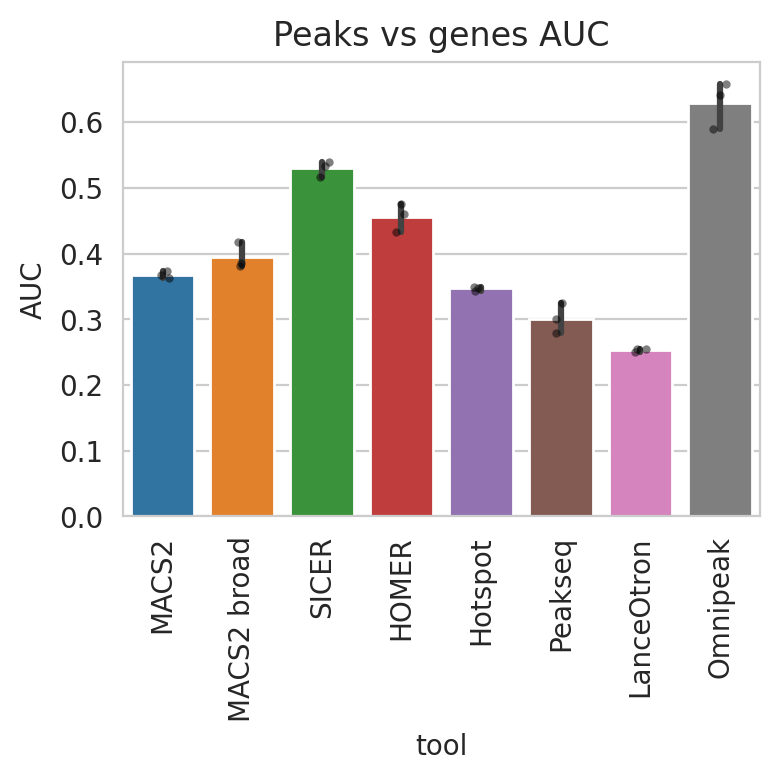

In [57]:
print('Immune')
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Peaks vs genes AUC')
g_results = sns.barplot(data=immune_genes_aps_df, x='tool', y='auc',
                        # capsize=.2, err_kws={'linewidth': 2},
                        palette=TOOLS_PALETTE,
                        order=TOOLS,
                        ax=ax)
sns.stripplot(data=immune_genes_aps_df, x='tool', y='auc',
              dodge=True, size=3, color="black", alpha=0.5,
              order=TOOLS,
              ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('AUC')
plt.tight_layout()
plt.show()

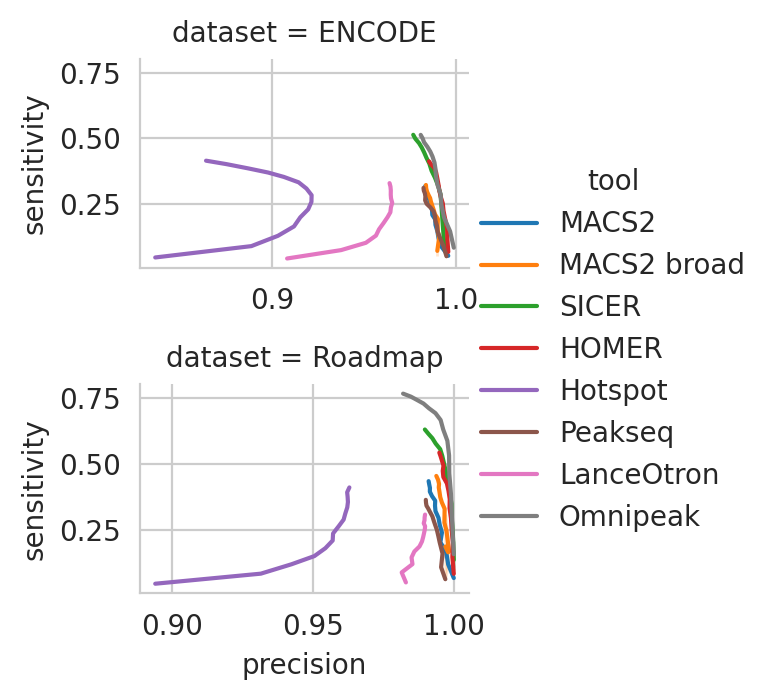

In [58]:
t1 = encode_genes_ovlp_df[(encode_genes_ovlp_df['cell'] == 'H1') &
                          (encode_genes_ovlp_df['replicate'] == 'rep1')].copy()
t1['dataset'] = 'ENCODE'
t2 = immune_genes_ovlp_df[(immune_genes_ovlp_df['cell'] == 'TCell') &
                          (immune_genes_ovlp_df['replicate'] == '')].copy()
t2['dataset'] = 'Roadmap'
covlp_df = pd.concat([t1, t2]).reset_index(drop=True)
g = sns.FacetGrid(covlp_df, hue="tool", row="dataset", height=1.8, aspect=1.5, sharex=False,
                  palette=TOOLS_PALETTE, hue_order=TOOLS)
g.map(sns.lineplot, "precision", "sensitivity", markers=True, sort=False)
g.add_legend()
plt.show()


Roadmap + ENCODE


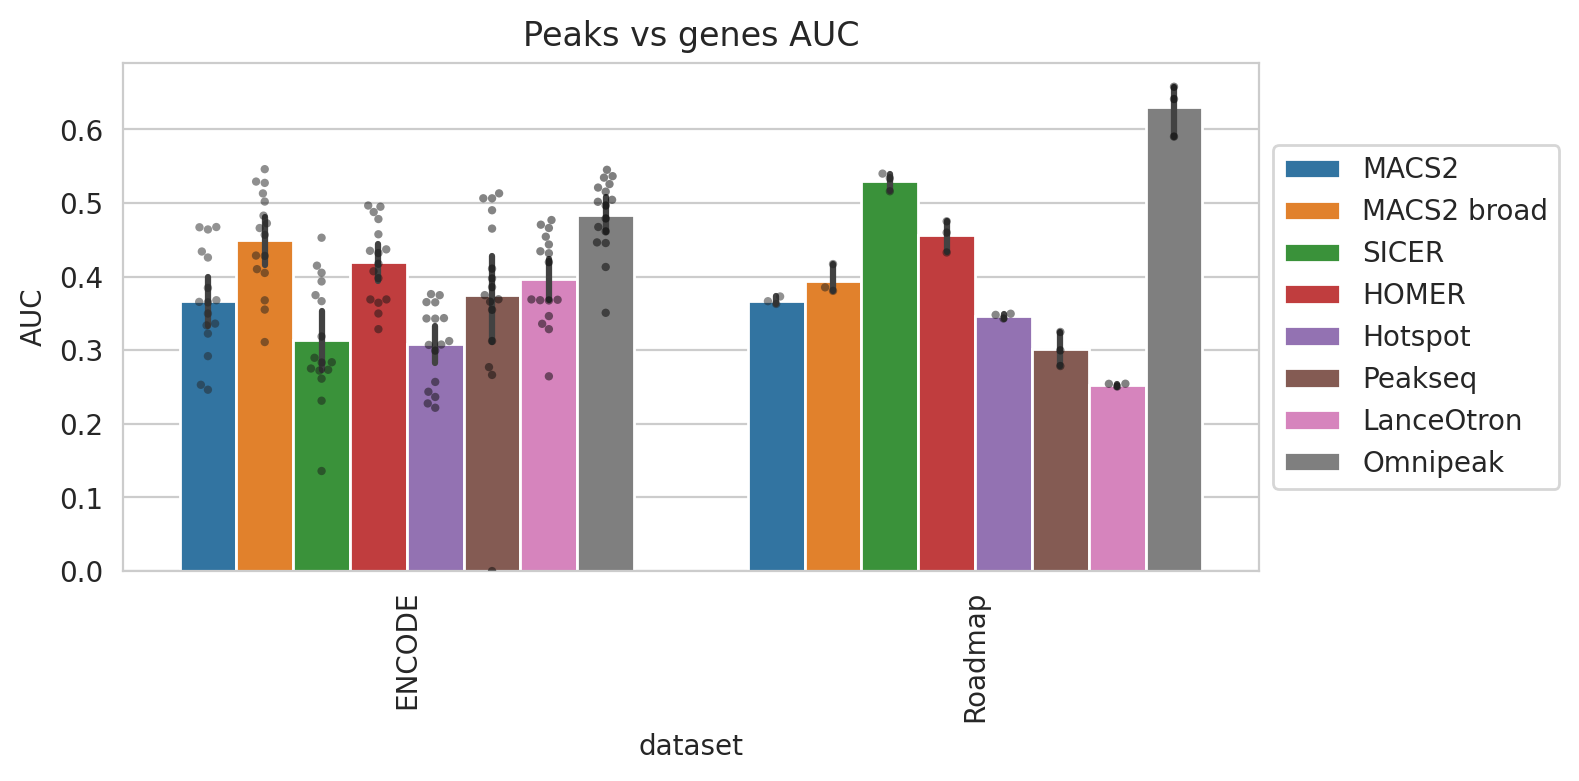

In [59]:
print('Roadmap + ENCODE')
encode_genes_aps_df['dataset'] = 'ENCODE'
immune_genes_aps_df['dataset'] = 'Roadmap'
t = pd.concat([encode_aps_df, immune_genes_aps_df]).reset_index(drop=True)
plt.figure(figsize=(8, 4))
ax = plt.axes()
ax.title.set_text('Peaks vs genes AUC')
sns.barplot(data=t, x='dataset', y='auc', hue='tool',
            # capsize=.2, err_kws={'linewidth': 2},
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            ax=ax)
sns.swarmplot(data=t, x='dataset', y='auc', hue='tool',
              dodge=True, size=3, color="black", alpha=0.5, palette='dark:black',
              hue_order=TOOLS,
              legend=False,
              ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('AUC')
plt.tight_layout()
plt.show()

# END